# Summary

Apparently this notebook compares results from the CMW weighted value vs. the not weighted value

---

In [1]:
import sys
sys.path.append("/Users/zsombi/OneDrive/PoPy")

from popy.decoding.population_decoders import *
from popy.plotting.plotting_tools import plot_keypoints
import popy.config as cfg
import os
from itertools import product
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# plot venn diagram of the significant units of model 'no cmw short history' and 'cmw short history'
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles
import seaborn as sns

from popy.decoding.decoder_tools import mask_N_consecutives



In [2]:
# load results
def load_res(fname, target):
    floc = os.path.join(cfg.PROJECT_PATH_LOCAL, 'notebooks', 'decoders', 'glm', 'results', 
                        f'{fname}_target_{target}',
                        'scores.nc')
    print(f'loading {floc}')
    
    ds = xr.open_dataset(floc)
    ds.close()
    return ds.copy("deep")

# plotting functions
def plot_summary_statistic(dss_original, plotting_func, title=None, p_lim=0.05, theme=None):
    dss = [ds.copy() for ds in dss_original]
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    if not title is None:
        plt.suptitle(title)

    #colors = {'LPFC': 'tab:blue', 'MCC': 'grey'}
    # iterable tab colorsú
    if theme is None:
        colors = cm.get_cmap('tab10').colors
    elif theme == 1:
        colors = {'LPFC': 'tab:blue', 'MCC': 'grey'}
        styles = ['-', '--', '-.', ':', ':']
        styles = {ds.attrs['model_name']: styles[i] for i, ds in enumerate(dss)}

    for m, monkey in enumerate(['ka', 'po']):
        for a, area in enumerate(['LPFC', 'MCC']):
            ax = axs[m, a]

            # get results of the two models for the current area and monkey
            for i_ds, ds in enumerate(dss):
                ds_curr = ds.sel(unit = (ds.monkey == monkey) & (ds.area == area))
                ax.plot(ds.time.values, plotting_func(ds_curr, p_lim=p_lim), 
                        color=colors[area] if theme == 1 else colors[i_ds],
                        linestyle=styles[ds.attrs["model_name"]] if theme == 1 else '-',
                        lw=1, 
                        label=f'{ds.attrs["model_name"]}, N={(~np.isnan(ds_curr["scores"])).sum("unit")[0].values}')#, linestyle=styles[ds.attrs["model_name"]])

            # legend below plot
            ax.legend(loc='upper right')

            # plot key points
            plot_keypoints(ax, n_extra_trials=-1, fontsize=8, xlabels='both')
            ax.grid(alpha=0.3)
            
            # set title and labels
            ax.set_title(f'monkey: {monkey}, area: {area}')
            ax.set_ylabel(f'prop. of significant units')
            ax.set_xlabel('time (s)')
            # hide spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

    plt.tight_layout()

    return fig, ax

# define summary statistic functions
def mean_scores(ds, p_lim=0.05):
    return np.nanmean(ds['scores'], axis=0)
def mean_scores_signif(ds, p_lim=0.05):
    ds = ds.where(ds['p_vals'] <= p_lim)
    return np.nanmean(ds['scores'], axis=0)
def prop_significants(ds, p_lim=0.05):
    n_non_nan_units = (~np.isnan(ds['scores'])).sum('unit')
    n_significant_units = (ds['p_vals'] <= p_lim).sum('unit')
    return n_significant_units / n_non_nan_units
    #return np.nanmean(ds['p_vals'] <= p_lim, axis=0)
def n_significants(ds, p_lim=0.05):
    n_significant_units = (ds['p_vals'] <= p_lim).sum('unit')
    return n_significant_units

# History representation

In [5]:
p_lim = 0.05

# load data - 1-1 xarray datasets for all the conditions
fnames = {
    #'cmw current fb': 'cmw_curr_fb_CPD',
    'no cmw long history': 'no_cmw_long_history_CPD',
    'no cmw short history': 'no_cmw_short_history_CPD',
    'cmw long history': 'cmw_long_history_CPD',
    'cmw short history': 'cmw_short_history_CPD'
    }
"""
'no cmw long history': 'past_fb_cpd',
'no cmw short history': 'last_fb_reduced_cpd',
'cmw short history': 'cmw_short_history_CPD'"""

"\n'no cmw long history': 'past_fb_cpd',\n'no cmw short history': 'last_fb_reduced_cpd',\n'cmw short history': 'cmw_short_history_CPD'"

## Compare models

loading /Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/notebooks/decoders/glm/results/no_cmw_long_history_CPD_target_None/scores.nc
loading /Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/notebooks/decoders/glm/results/no_cmw_short_history_CPD_target_None/scores.nc
loading /Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/notebooks/decoders/glm/results/cmw_long_history_CPD_target_None/scores.nc
loading /Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/notebooks/decoders/glm/results/cmw_short_history_CPD_target_None/scores.nc


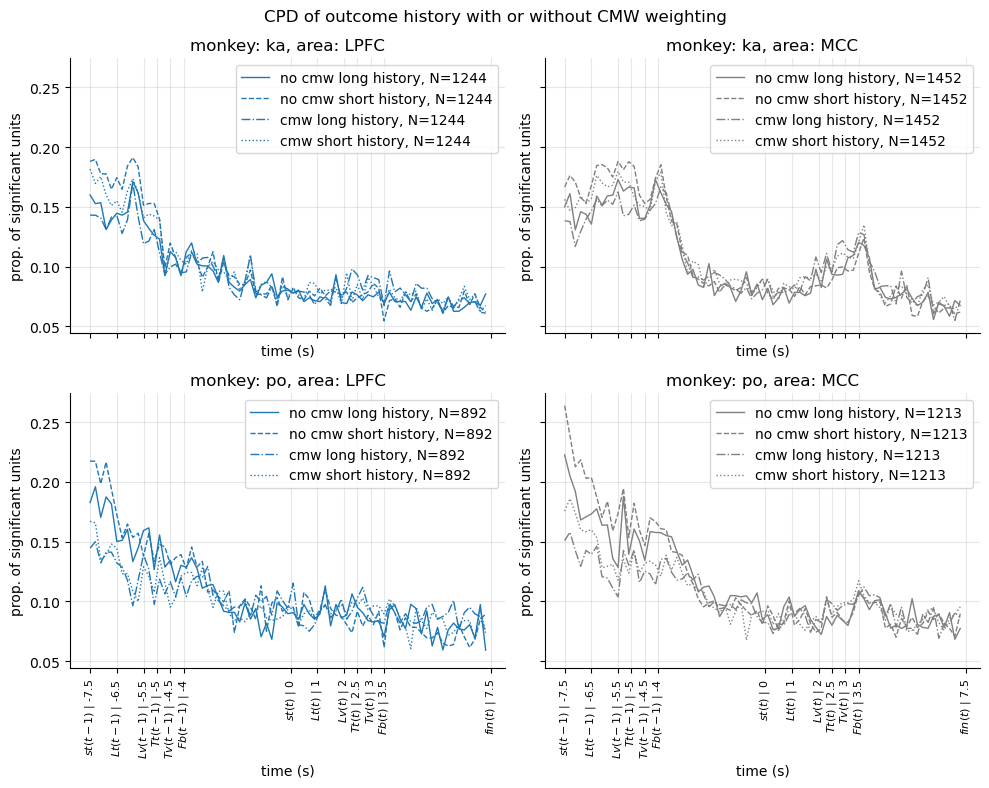

In [6]:
dss = []
for model_name, fname in fnames.items():
    ds = load_res(fname, target=None)
    # shift time dimension with -7.5s 
    ds['time'] = ds['time'] - (7.5 + ds['time'].values[0])  # shift time dimension with -7.5s if not like that already
    ds.attrs['model_name'] = model_name
    dss.append(ds)

plotting_func = prop_significants  # prop_significants
plot_summary_statistic(dss, plotting_func, title= f'CPD of outcome history with or without CMW weighting', p_lim=p_lim, theme=1)
plt.show()

## Comparet targets

In [7]:
'''targets_of_interest = [None, '1', '2', '3', 'random']
model_name = 'cmw short history'

dss = []
for target in targets_of_interest:
    ds = load_res(fnames[model_name], target=target)
    # shift time dimension with -7.5s
    ds['time'] = ds['time'] - (7.5 + ds['time'].values[0]) 
    ds.attrs['model_name'] = target
    dss.append(ds)

plotting_func = prop_significants  # prop_significants
plot_summary_statistic(dss, plotting_func, title= model_name, p_lim=p_lim)
plt.show()'''

"targets_of_interest = [None, '1', '2', '3', 'random']\nmodel_name = 'cmw short history'\n\ndss = []\nfor target in targets_of_interest:\n    ds = load_res(fnames[model_name], target=target)\n    # shift time dimension with -7.5s\n    ds['time'] = ds['time'] - (7.5 + ds['time'].values[0]) \n    ds.attrs['model_name'] = target\n    dss.append(ds)\n\nplotting_func = prop_significants  # prop_significants\nplot_summary_statistic(dss, plotting_func, title= model_name, p_lim=p_lim)\nplt.show()"

#  Set of units at time of interest

In [8]:
def extract_unit_uinfo(fnames, time_of_interest, p_lim):
    #for both models, collect all units, if they are significant at the time of interest, and the mean score at that time of interest
    # only for the full models
    units = []
    for model_name, fname in fnames.items():
        ds = load_res(fname, target=None)
        # shift time dimension with -7.5s
        ds['time'] = ds['time'] - (7.5 + ds['time'].values[0]) 
        
        # select time of interest
        ds = ds.sel(time = slice(time_of_interest[0], time_of_interest[1]))
        print(f"n time bins ={len(ds['time'])}")
            
        # how many units are significant at the time of interest
        n_non_nan_units = (~np.isnan(ds['scores'])).sum('time')
        n_signif = (ds['p_vals'] <= p_lim).sum('time')
        max_score = ds.where(ds['p_vals'] <= p_lim)['scores'].max('time')

        # add to the dataframe
        for i, unit_name in enumerate(ds['unit'].values):
            units.append({'unit_name': unit_name, 'model': model_name, 'n_non_nan_units': n_non_nan_units[i].values,
                        'n_signif': n_signif[i].values, 'max_score': max_score[i].values})

    df = pd.DataFrame(units)
    
    # sort by unit name, then model
    df = df.sort_values(by=['unit_name', 'model'])
    
    return df

def basic_analysis(df, models, title=None):
    # print information
    for model_name in models:
        n_units_model = len(df[df['model'] == model_name]['unit_name'].unique())
        n_non_nan_units_model = len(df[(df['model'] == model_name) & (df['n_non_nan_units'] > 0)]['unit_name'].unique())
        print(f'Number of non-nan units in {model_name}: {n_non_nan_units_model}/{n_units_model}')

        n_signifs_units = len(df[(df['model'] == model_name) & (df['n_signif'] > 0)]['unit_name'].values)
        print(f'Number of units with any significant score in {model_name}: {n_signifs_units}/{n_non_nan_units_model}')

    # print the number of significant units for sanity
    signifs_1 = df[(df['model'] == models[0]) & (df['n_signif'] > 0)]['unit_name'].values
    signifs_2 = df[(df['model'] == models[1]) & (df['n_signif'] > 0)]['unit_name'].values
    n_both = len(set(signifs_1).intersection(set(signifs_2)))
    n_just_1 = len(set(signifs_1).difference(set(signifs_2)))
    n_just_2 = len(set(signifs_2).difference(set(signifs_1)))

    print(f'Number of significant units in the two models: {n_both}')
    print(f'Number of significant units only in the first model: {n_just_1}')
    print(f'Number of significant units only in the second model: {n_just_2}')
                                            
    # plot venn diagram
    plt.figure()
    venn2([set(signifs_1), set(signifs_2)], set_labels = (models[0], models[1]))
    if title is not None:
        plt.title(title)
    else:
        plt.title('Significant units of the two models')
    plt.show()
    
def compare_scores_intersection(df, models, title=None, xlim=None):

    # plot the scores of the units of intersection
    fig, ax = plt.subplots(1, 1, figsize=(4, 5))    

    # get the units of intersection
    signifs_1 = df[(df['model'] == models[0]) & (df['n_signif'] > 0)]['unit_name'].values
    signifs_2 = df[(df['model'] == models[1]) & (df['n_signif'] > 0)]['unit_name'].values
    signifs_both = set(signifs_1).intersection(set(signifs_2))

    # get the units of intersection
    df_of_interest = df[(df['unit_name'].isin(signifs_both)) & (df['model'].isin(models))]
    
    values_diff = {}
    for unit_name, scores_df in df_of_interest.groupby('unit_name'):
        scores_1 = scores_df[scores_df['model'] == models[0]]['max_score'].values[0]
        scores_2 = scores_df[scores_df['model'] == models[1]]['max_score'].values[0]
        values_diff[unit_name] = scores_1 - scores_2

    # sort by the difference
    values_diff = {k: v for k, v in sorted(values_diff.items(), key=lambda item: item[1])}

    colors = ['tab:red' if x < 0 else 'tab:blue' for x in list(values_diff.values())]
    plt.barh(list(values_diff.keys()), list(values_diff.values()), color=colors, height=1)
    # Manually creating two labels for the legend, 
    legend_elements = [Patch(facecolor='tab:blue', label=f'model "{models[0]}" > model "{models[1]}"'),
                       Patch(facecolor='tab:red', label=f'model "{models[0]}" < model "{models[1]}"')]
    # legend below plot
    ax.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=1)

    # center around x=0
    if xlim is None:
        Q = np.quantile(list(values_diff.values()), [0.01, 0.99])
        max_abs_diff = np.abs(Q).max()
        ax.set_xlim(-max_abs_diff, max_abs_diff)
    else:
        ax.set_xlim(xlim)
    ax.set_ylabel(f'unit, N={len(values_diff.keys())}')
    ax.set_xlabel(f'CPD difference\n"{models[0]}" - "{models[1]}"')
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title('Difference in CPD of the significant units')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()
    
def all_models_in_violin(df, title=None, ylim=None):
    fig, ax = plt.subplots(1, 1, figsize=(4, 5))
    model_names = df['model'].unique()
    for i, model_name in enumerate(model_names):
        signif_scores = df[(df['model'] == model_name) & (df['n_signif'] > 0)]
        sns.violinplot(x=i, y=signif_scores['max_score'].values.astype(float), ax=ax, alpha=0.5, label=model_name)

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_ylabel(f'distr. of significant CPDs')
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=90)
    ax.grid(alpha=0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [9]:
time_of_interest = [2.5, 3.7]

df = extract_unit_uinfo(fnames, time_of_interest, p_lim)
df

loading /Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/notebooks/decoders/glm/results/no_cmw_long_history_CPD_target_None/scores.nc
n time bins =7
loading /Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/notebooks/decoders/glm/results/no_cmw_short_history_CPD_target_None/scores.nc
n time bins =7
loading /Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/notebooks/decoders/glm/results/cmw_long_history_CPD_target_None/scores.nc
n time bins =7
loading /Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/notebooks/decoders/glm/results/cmw_short_history_CPD_target_None/scores.nc
n time bins =7


,unit_name,model,n_non_nan_units,n_signif,max_score
9783,ka_010720_LPFC_04_01,cmw long history,7,1,0.03764119714434366
14613,ka_010720_LPFC_04_01,cmw short history,7,0,nan
123,ka_010720_LPFC_04_01,no cmw long history,7,1,0.026369953836839932
4953,ka_010720_LPFC_04_01,no cmw short history,7,0,nan
9784,ka_010720_LPFC_05_01,cmw long history,7,2,0.03838040948679278
...,...,...,...,...,...
9505,po_310822_MCC_13_02,no cmw short history,7,2,0.014216326748424102
14272,po_310822_MCC_16_01,cmw long history,7,0,nan
19054,po_310822_MCC_16_01,cmw short history,7,0,nan
4676,po_310822_MCC_16_01,no cmw long history,7,0,nan


## List of units per example model

In [10]:
model_name = 'no cmw long history'
list_of_units = df[(df['model'] == model_name) & (df['n_non_nan_units'] > 0) & (df['n_signif'] >= df['n_non_nan_units']-2)]
# print(list_of_units['unit_name'].values)

In [31]:
(list(list_of_units['max_score'].values)[0]).item()

0.042866941324243846

In [33]:
{unit_name: cpd.item() for unit_name, cpd in zip(list_of_units['unit_name'].values, list_of_units['max_score'].values)}

{'ka_010720_MCC_05_01': 0.042866941324243846,
 'ka_010720_MCC_07_02': 0.031421737297090524,
 'ka_010720_MCC_08_01': 0.031337329107345324,
 'ka_020622_MCC_06_01': 0.08692512765567761,
 'ka_020622_MCC_09_01': 0.10416637212019464,
 'ka_020622_MCC_10_01': 0.06395394931292908,
 'ka_020622_MCC_15_02': 0.12440460978457302,
 'ka_030322_MCC_08_02': 0.03890058114583095,
 'ka_030322_MCC_09_01': 0.09152686819539235,
 'ka_040321_MCC_09_01': 0.04713319008201433,
 'ka_040321_MCC_10_02': 0.12011985997775754,
 'ka_050620_MCC_08_02': 0.08931168030986747,
 'ka_050620_MCC_08_03': 0.059588386787081005,
 'ka_050620_MCC_09_02': 0.10076562027155733,
 'ka_050820_LPFC_04_01': 0.06853487844193595,
 'ka_050820_LPFC_05_02': 0.07871703555313758,
 'ka_050820_LPFC_06_01': 0.03091478105710499,
 'ka_050820_LPFC_08_01': 0.030953041760930944,
 'ka_050820_LPFC_10_01': 0.034660200773793726,
 'ka_101220_MCC_05_01': 0.0785241587354083,
 'ka_150221_MCC_07_02': 0.06779249917530561,
 'ka_150622_MCC_05_03': 0.3653515934468714,
 

## Distribution of weights per model

### All models together

#### Both areas and monkeys

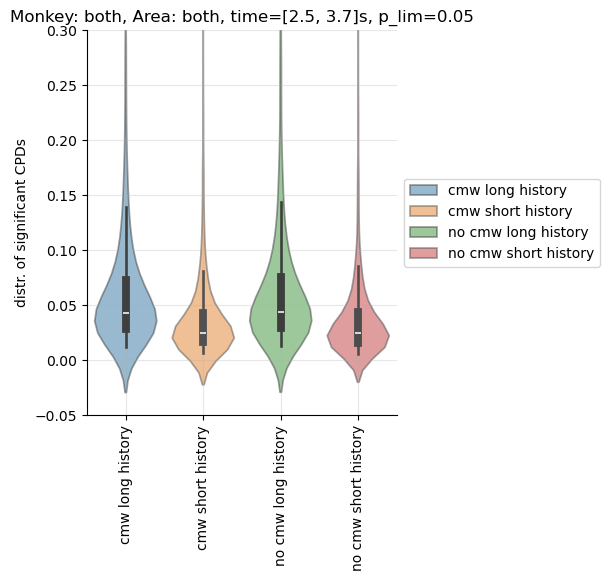

In [ ]:
title = f'Monkey: both, Area: both, time={time_of_interest}s, p_lim={p_lim}'
all_models_in_violin(df, title=title, ylim=[-0.05, 0.3])

#### Areas and monkeys separately

In [ ]:
'''for monkey, area in product(['ka', 'po'], ['LPFC', 'MCC']):
    df_curr = df[(df['unit_name'].str.contains(monkey)) & (df['unit_name'].str.contains(area))]       # get current monkey and area

    title = f'Monkey: {monkey}, Area: {area}, time={time_of_interest}s, p_lim={p_lim}'
    all_models_in_violin(df_curr, title=title, ylim=[-0.05, 0.3])'''

"for monkey, area in product(['ka', 'po'], ['LPFC', 'MCC']):\n    df_curr = df[(df['unit_name'].str.contains(monkey)) & (df['unit_name'].str.contains(area))]       # get current monkey and area\n\n    title = f'Monkey: {monkey}, Area: {area}, time={time_of_interest}s, p_lim={p_lim}'\n    all_models_in_violin(df_curr, title=title, ylim=[-0.05, 0.3])"

## Compare cmw to no cmw

In [ ]:
models = ['no cmw short history', 'cmw short history']

### Both areas and monkeys

Number of non-nan units in no cmw short history: 4807/4830
Number of units with any significant score in no cmw short history: 2000/4807
Number of non-nan units in cmw short history: 4807/4830
Number of units with any significant score in cmw short history: 2097/4807
Number of significant units in the two models: 1384
Number of significant units only in the first model: 616
Number of significant units only in the second model: 713


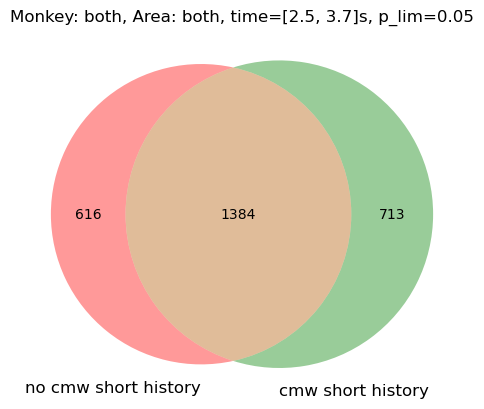

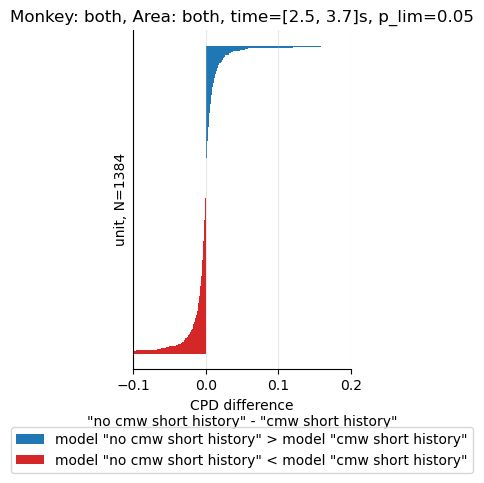

In [ ]:
basic_analysis(df, models, title=f'Monkey: both, Area: both, time={time_of_interest}s, p_lim={p_lim}')
compare_scores_intersection(df, models, title=f'Monkey: both, Area: both, time={time_of_interest}s, p_lim={p_lim}', xlim=(-0.1, 0.2))

### Areas and monkeys separately

Number of non-nan units in no cmw short history: 1244/1253
Number of units with any significant score in no cmw short history: 490/1244
Number of non-nan units in cmw short history: 1244/1253
Number of units with any significant score in cmw short history: 499/1244
Number of significant units in the two models: 355
Number of significant units only in the first model: 135
Number of significant units only in the second model: 144


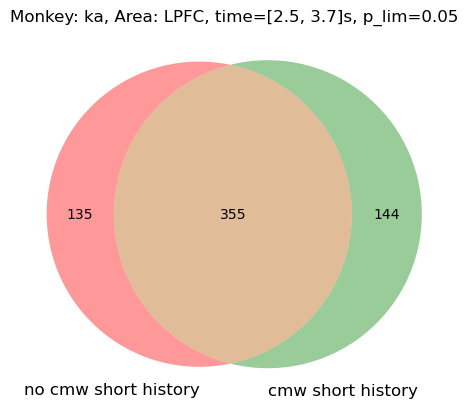

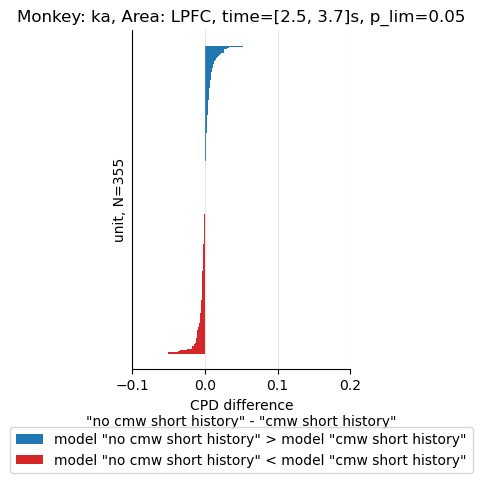

Number of non-nan units in no cmw short history: 1454/1462
Number of units with any significant score in no cmw short history: 624/1454
Number of non-nan units in cmw short history: 1454/1462
Number of units with any significant score in cmw short history: 662/1454
Number of significant units in the two models: 499
Number of significant units only in the first model: 125
Number of significant units only in the second model: 163


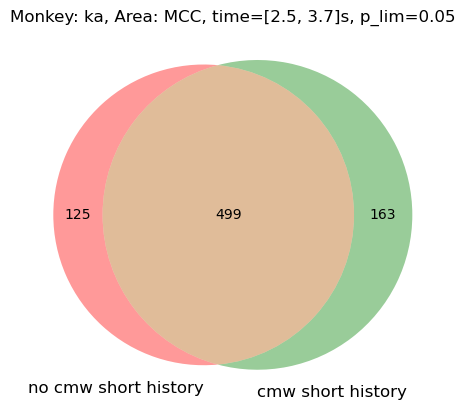

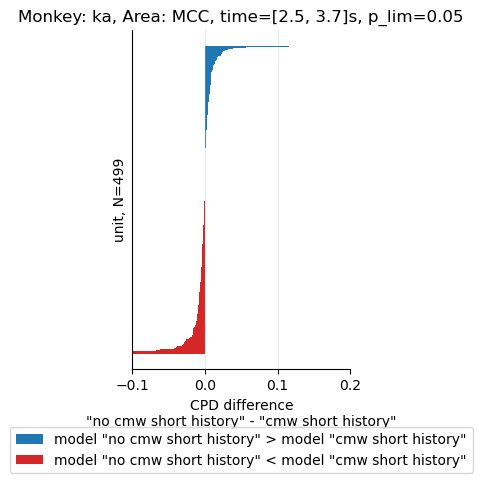

Number of non-nan units in no cmw short history: 895/898
Number of units with any significant score in no cmw short history: 371/895
Number of non-nan units in cmw short history: 895/898
Number of units with any significant score in cmw short history: 389/895
Number of significant units in the two models: 214
Number of significant units only in the first model: 157
Number of significant units only in the second model: 175


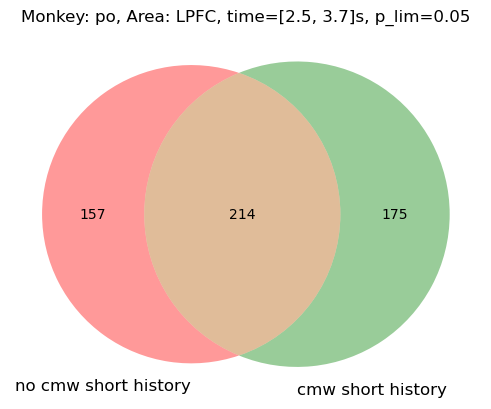

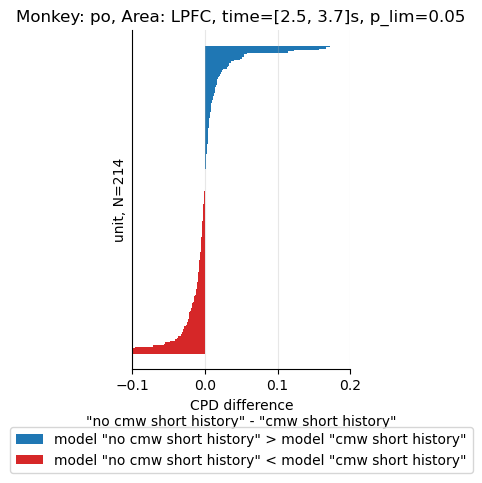

Number of non-nan units in no cmw short history: 1214/1217
Number of units with any significant score in no cmw short history: 515/1214
Number of non-nan units in cmw short history: 1214/1217
Number of units with any significant score in cmw short history: 547/1214
Number of significant units in the two models: 316
Number of significant units only in the first model: 199
Number of significant units only in the second model: 231


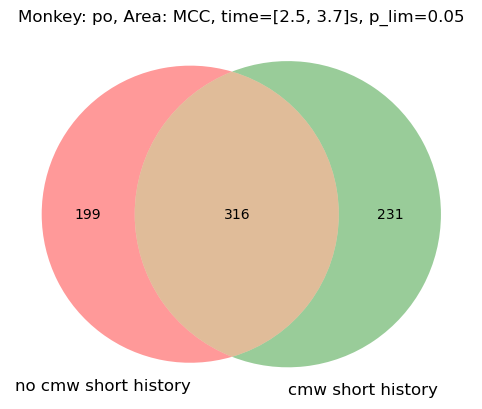

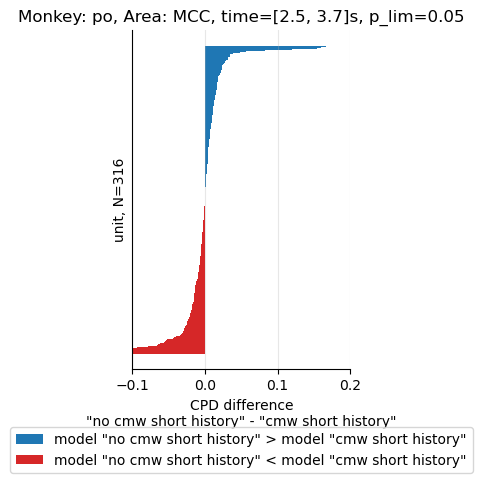

In [ ]:
for monkey, area in product(['ka', 'po'], ['LPFC', 'MCC']):
    df_curr = df[(df['unit_name'].str.contains(monkey)) & (df['unit_name'].str.contains(area))]       # get current monkey and area

    basic_analysis(df_curr, models, title=f'Monkey: {monkey}, Area: {area}, time={time_of_interest}s, p_lim={p_lim}')
    compare_scores_intersection(df_curr, models, title=f'Monkey: {monkey}, Area: {area}, time={time_of_interest}s, p_lim={p_lim}', xlim=(-0.1, 0.2))

# Time resolved thigy

In [ ]:
'''ds_no_cmw = load_res(fnames[models[0]], target=None)
ds_no_cmw_pvals = ds_no_cmw.p_vals.values
ds_no_cmw_units = ds_no_cmw.unit.values
ds_no_cmw_time = ds_no_cmw.time.values - 7.5

ds_cmw = load_res(fnames[models[1]], target=None)
ds_cmw_pvals = ds_cmw.p_vals.values
ds_cmw_units = ds_cmw.unit.values
ds_cmw_time = ds_cmw.time.values - 7.5'''

'ds_no_cmw = load_res(fnames[models[0]], target=None)\nds_no_cmw_pvals = ds_no_cmw.p_vals.values\nds_no_cmw_units = ds_no_cmw.unit.values\nds_no_cmw_time = ds_no_cmw.time.values - 7.5\n\nds_cmw = load_res(fnames[models[1]], target=None)\nds_cmw_pvals = ds_cmw.p_vals.values\nds_cmw_units = ds_cmw.unit.values\nds_cmw_time = ds_cmw.time.values - 7.5'

In [ ]:
def prop_overlap(list1, list2):
    return len(set(list1).intersection(set(list2))) / len(set(list1).union(set(list2)))

res = np.zeros((len(ds_cmw_time), len(ds_no_cmw_time)))
for t_cmw, time_of_interest_cmw in enumerate(ds_cmw_time):
    for t_no_cmw, time_of_interest_no_cmw in enumerate(ds_no_cmw_time):
        # select time of interest
        no_cmw_signif_units = ds_no_cmw_units[ds_no_cmw_pvals[:, t_no_cmw] <= p_lim]
        cmw_signif_units = ds_cmw_units[ds_cmw_pvals[:, t_cmw] <= p_lim]
        
        res[t_cmw, t_no_cmw] = prop_overlap(no_cmw_signif_units, cmw_signif_units)

NameError: name 'ds_cmw_time' is not defined

Text(0, 0.5, 'time (s)\n model: no cmw long history')

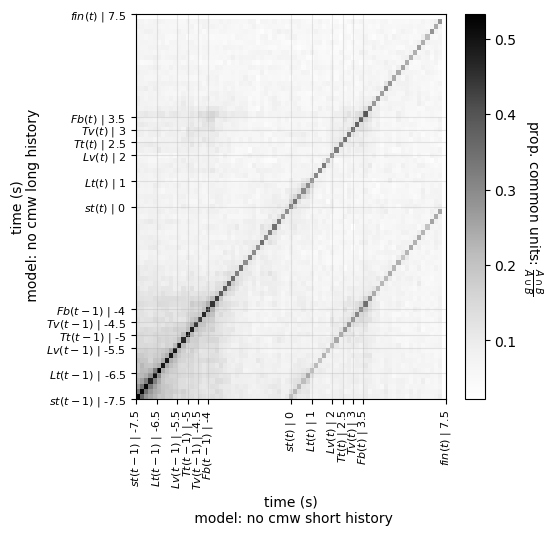

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cax = ax.matshow(res, cmap='Greys', aspect='auto', origin='lower', extent=[ds_no_cmw_time[0], ds_no_cmw_time[-1], ds_cmw_time[0], ds_cmw_time[-1]])

# set this to the cbar title: $A \union B / A \cap B$ in latex format
fig.colorbar(cax).set_label(r'prop. common units: $\frac{A \cap B}{A \cup B}$', rotation=270, labelpad=20)
plot_keypoints(ax, n_extra_trials=-1, fontsize=8, xlabels='both', axis='both')
# plot xticks BELOW
ax.xaxis.set_ticks_position('bottom')

ax.grid(alpha=0.3)
ax.set_xlabel(f'time (s)\n model: {models[0]}')
ax.set_ylabel(f'time (s)\n model: {models[1]}')

In [ ]:
# for the venn diagram:
t_1, t2 = 3, 4
units_to_venn = []
for t_no_cmw, time_of_interest_no_cmw in enumerate(ds_no_cmw_time):
    if time_of_interest_no_cmw >= t_1 and time_of_interest_no_cmw <= t2:
        no_cmw_signif_units = ds_no_cmw_units[ds_no_cmw_pvals[:, t_no_cmw] <= p_lim]
        units_to_venn.append((time_of_interest_no_cmw, no_cmw_signif_units))

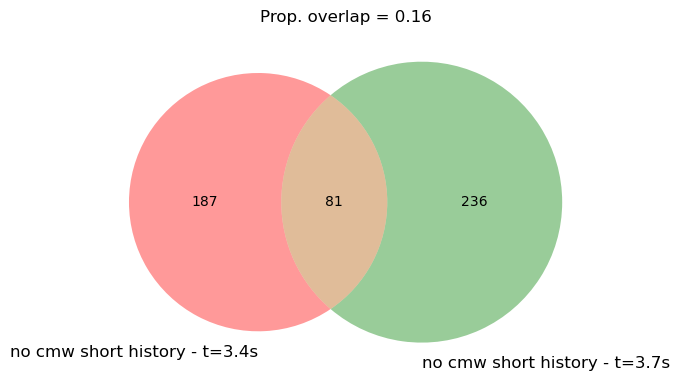

In [ ]:
# plot venn
t_id_1, t_id_2 = 2, 3
plt.figure()
venn2([set(units_to_venn[t_id_1][1]), set(units_to_venn[t_id_2][1])], set_labels = (f'no cmw short history - t={units_to_venn[t_id_1][0]:.1f}s', f'no cmw short history - t={units_to_venn[t_id_2][0]:.1f}s'))
plt.title(f'Prop. overlap = {prop_overlap(units_to_venn[t_id_1][1], units_to_venn[t_id_2][1]):.2f}')
plt.show()
